In [1]:
import numpy as np
import pandas as pd
from collections import deque
from scipy.special import comb
import copy

# Data Preprocessing
- There are $x_{1}$~$x_{6}$ six vairables in Bayesian network.
- Read frequency of each event represented by each variable.
- Calculate marginal and conditional probabilites for each variable

In [2]:
# Marginal probability for each variable.Rows represent vairables, columns represent probabilities
Px=[[78,1.5,5.5,15], # x1
    [27.5,32,2.5,17,21], #x2
    [18,66,16], #x3
    [71.5,10.5,1,17], #x4
    [37.5,11,10.5,41], #x5
    [1.5,32,14,31.5,21]] #x6
# Frequency for each value of each variable. Rows represent variables, columns represent values
freqx=[[156,3,11,30],
       [55,64,5,34,42],
       [36,132,32],
       [143,21,2,34],
       [75,22,21,82],
       [3,64,28,63,42]]
# CPDs' frequency. Rows in CPDs are variable that probabilty is conditioned on. 
# Columns are variable whose probability should be determined
P_x2_x1=[[36,57,4,27,32],
         [2,0,0,0,1],
         [5,1,0,2,3],
         [12,6,1,5,6]]
P_x4_x1=[[115,12,2,27],
         [3,0,0,0],
         [8,3,0,0],
         [17,6,0,7]]
P_x6_x1=[[3,44,20,55,34],
         [0,2,1,0,0],
         [0,6,1,2,2],
         [0,12,6,6,6]]
P_x3_x2=[[7,41,7],
         [17,42,5],
         [1,4,0],
         [6,24,4],
         [5,21,16]]
P_x5_x2=[[23,4,6,22],
         [22,7,8,27],
         [3,2,0,0],
         [13,5,4,12],
         [14,4,3,21]]
P_x2_x3=[[7,17,1,6,5],
         [41,42,4,24,21],
         [7,5,0,4,16]]
P_x5_x3=[[13,3,8,12],
         [52,15,12,53],
         [10,4,1,17]]
P_x6_x3=[[0,14,3,13,6],
         [3,42,20,40,27],
         [0,8,5,10,9]]
P_x1_x4=[[115,3,8,17],
         [12,0,3,6],
         [2,0,0,0],
         [27,0,0,7]]
P_x2_x4=[[44,46,4,22,28],
         [5,6,0,4,6],
         [0,2,0,0,0],
         [6,11,1,8,8]]
P_x6_x4=[[3,40,22,47,31],
         [0,12,3,4,2],
         [0,0,0,1,1],
         [0,12,3,11,8]]
P_x2_x5=[[23,22,3,13,14],
         [4,7,2,5,4],
         [6,8,0,4,3],
         [22,27,0,12,21]]
P_x3_x5=[[13,52,10],
         [3,15,4],
         [8,12,1],
         [12,53,17]]
P_x1_x6=[[3,0,0,0],
         [44,2,6,12],
         [20,1,1,6],
         [55,0,2,6],
         [34,0,2,6]]
P_x2_x6=[[0,1,0,2,0],
         [18,19,0,15,12],
         [6,11,0,4,7],
         [20,20,5,6,12],
         [11,13,0,7,11]]
P_x3_x6=[[0,3,0],
         [14,42,8],
         [3,20,5],
         [13,40,10],
         [6,27,9]]
P_x4_x6=[[3,0,0,0],       # x6=0
         [40,12,0,12],# x6=1
         [22,3,0,3],
         [47,4,1,11],
         [31,2,1,8]]

In [3]:
# Divide element by 100
def prepCPD(p):
    for i in range(len(p)):
        total=0
        for j in range(len(p[0])):
            total=total+p[i][j]
        for j in range(len(p[0])):
            p[i][j]=p[i][j]/total*100
prepCPD(P_x2_x1)
prepCPD(P_x4_x1)
prepCPD(P_x6_x1)
prepCPD(P_x3_x2)
prepCPD(P_x5_x2)
prepCPD(P_x2_x3)
prepCPD(P_x5_x3)
prepCPD(P_x6_x3)
prepCPD(P_x1_x4)
prepCPD(P_x2_x4)
prepCPD(P_x6_x4)
prepCPD(P_x2_x5)
prepCPD(P_x3_x5)
prepCPD(P_x1_x6)
prepCPD(P_x2_x6)
prepCPD(P_x3_x6)
prepCPD(P_x4_x6)

# Task 1
 Investigate the dependencies between different variables. The evaluation metrics are
- Difference between two probabilies: $P(x_{1})*P(x_{2})$ and $P(x_{1},x_{2})$
- Cross entropy or KL divergence

In [4]:
#p(x1); p(x2); p(x3); p(x4); p(x5); p(x6)
#p(x2|x1),p(x4|x1),p(x6|x1)
#p(x3|x2),p(x5|x2)
#p(x2|x3),p(x5|x3),p(x6|x3)
#p(x1|x4),p(x2|x4),p(x6|x4)
#p(x2|x5),p(x3|x5)
#p(x1|x6),p(x2|x6),p(x3|x6),p(x4|x6)


def getJointMul(Px,var_prefix):# return dict whose keys are "x1_x2" like strings,values are probability matrix
    J_x_J_y={}
    for i in range(0,len(Px)-1):# enumerate distribiton of two variables
        for j in range(i+1,len(Px)):
            x=Px[i]
            y=Px[j]
            out=np.zeros((len(x),len(y)))
            for u in range(0,len(x)):
                for v in range(0,len(y)):
                    out[u][v]=x[u]/100*y[v]/100
            s=var_prefix+str(i+1)+"_"+var_prefix+str(j+1)
            J_x_J_y[s]=out
    return J_x_J_y


def getJointfromCPD(cpd_label,cpd_value,var_label,Px):#return a pair whose first is joint probability dict and second is label dict
    J_x_y={}
    J_x_y_label={}
    for i in range(0,len(cpd_value)): # enumerate all the given CPDs
        label=cpd_label[i][1] # ith cpd's parent label
        index=var_label[label] # parent node's index in Px
        x=Px[index]
        y=cpd_value[i]
        out=np.zeros((len(y),len(y[0])))
        for u in range(0,len(y)):       # calculate joint probability from CPDs and prior
            for v in range(0,len(y[0])):
                out[u][v]=y[u][v]/100*x[u]/100
        a=cpd_label[i][0] 
        b=cpd_label[i][1]
        if int(a[1])<int(b[1]): # last char in x1,x2 ... in first sublabel.Save "x1_x2","x2_x3" in acceding order of last char
            name=a+"_"+b
            out=out.T
        else:
            name=b+"_"+a
        if name in J_x_y:
            J_x_y[name].append(out)
            J_x_y_label[name].append((a,b))
        else:
            J_x_y[name]=[out]
            J_x_y_label[name]=[(a,b)]
    return J_x_y,J_x_y_label
def AbsDiffCal(J_x_y,J_x_J_y):#return dict whose keys are "x1_x2" like strings, values are sum of absolute difference
    abs_probdiff={}
    for key, val in J_x_y.items():
        mul=J_x_J_y[key]
        temp=[]
        for i in range(0,len(val)):
            temp.append(np.sum(np.abs(mul-val[i])))
        abs_probdiff[key]=temp
    return abs_probdiff
def CrossEntropyCal(J_x_y,J_x_J_y): # cross entropy H(J_x_y,J_x_J_y),return corrsponding cross entropy, entropy of J_x_y and KL divergence
    crossentropy={}
    entropy={}
    KLdiv={}
    for key, val in J_x_y.items():
        mul=J_x_J_y[key]
        temp_cross=[]
        temp_entropy=[]
        temp_KL=[]
        for i in range(0,len(val)): # -J_x_y*log(J_x_J_y)
            a=np.sum(-val[i]*np.log(mul))
            b=np.sum(-val[i]*np.log(val[i]+1e-10)) # add small value to avoid zero element
            temp_cross.append(a)
            temp_entropy.append(b)
            temp_KL.append(a-b)
        crossentropy[key]=temp_cross
        entropy[key]=temp_entropy
        KLdiv[key]=temp_KL
    return crossentropy,entropy,KLdiv
def packIndicator(indicator,J_x_y_label):# format joint probability as a list of tuples
    out=[]
    for key,val in indicator.items():
        a=indicator[key]
        b=J_x_y_label[key]
        for i in range(len(a)):
            out.append(([b[i][0],b[i][1]],a[i]))# ([x1,x2],value) x2 is vairable to be conditioned on(parent)
    return out

### Calculate joint probabilites

In [5]:
# Set maps to check variables and CPDs convienently
var_label={"x1":0,"x2":1,"x3":2,"x4":3,"x5":4,"x6":5}
cpd_label=[["x2","x1"],["x4","x1"],["x6","x1"],# cpd formate [child,parent]
      ["x3","x2"],["x5","x2"],
      ["x2","x3"],["x5","x3"],["x6","x3"],
      ["x1","x4"],["x2","x4"],["x6","x4"],
      ["x2","x5"],["x3","x5"],
      ["x1","x6"],["x2","x6"],["x3","x6"],["x4","x6"]]
cpd_value=[P_x2_x1,P_x4_x1,P_x6_x1,# cpd matrix associatd with cpd_label
           P_x3_x2,P_x5_x2,
           P_x2_x3,P_x5_x3,P_x6_x3,
           P_x1_x4,P_x2_x4,P_x6_x4,
           P_x2_x5,P_x3_x5,
           P_x1_x6,P_x2_x6,P_x3_x6,P_x4_x6]
J_x_J_y=getJointMul(Px,"x")# get joint probabilities from the distribution of two variables
J_x_y,J_x_y_label=getJointfromCPD(cpd_label,cpd_value,var_label,Px)#get joint probability from CPDs

### Calculate the sum of absolute difference between two distributions

In [6]:
# Calculate the sum of absolute difference between two distributions
abs_probdiff=AbsDiffCal(J_x_y,J_x_J_y)
print("The sum of absolution difference: \n")
abs_probdiff

The sum of absolution difference: 



{'x1_x2': [0.1599999999999999],
 'x1_x4': [0.1196500000000001, 0.1196499999999999],
 'x1_x6': [0.16059999999999997, 0.16060000000000002],
 'x2_x3': [0.2182, 0.2182],
 'x2_x5': [0.12935000000000002, 0.12935],
 'x3_x5': [0.11560000000000004, 0.11560000000000001],
 'x3_x6': [0.09480000000000005, 0.09480000000000005],
 'x2_x4': [0.11496666666666663],
 'x4_x6': [0.1431999999999999, 0.14319999999999997],
 'x2_x6': [0.17489999999999997]}

### Calculate the cross entropy and KL divergence between two distributions

In [7]:

cross_entropy,entropy,KLdiv=CrossEntropyCal(J_x_y,J_x_J_y)
print("Cross entropy: ")
cross_entropy


Cross entropy: 


{'x1_x2': [2.1417169464090473],
 'x1_x4': [1.5246824882710392, 1.524682488271039],
 'x1_x6': [2.095375554775694, 2.095375554775694],
 'x2_x3': [2.3169472413698804, 2.3169472413698804],
 'x2_x5': [2.6536452038621077, 2.6536452038621077],
 'x3_x5': [2.0889318510341783, 2.0889318510341783],
 'x3_x6': [2.270605849736527, 2.270605849736527],
 'x2_x4': [2.263147821840503],
 'x4_x6': [2.2182847444264477, 2.2182847444264477],
 'x2_x6': [2.835319202564456]}

In [8]:
print("KL divergence: ")
KLdiv

KL divergence: 


{'x1_x2': [0.03529820100078451],
 'x1_x4': [0.034483748101127976, 0.034483748101127754],
 'x1_x6': [0.03203018671021729, 0.032030186710217734],
 'x2_x3': [0.0543844819396222, 0.0543844819396222],
 'x2_x5': [0.02944271775630458, 0.029442717756304138],
 'x3_x5': [0.02141460301494469, 0.021414603014944245],
 'x3_x6': [0.015071043569599318, 0.015071043569599762],
 'x2_x4': [0.023907520718517983],
 'x4_x6': [0.0321562548314005, 0.0321562548314005],
 'x2_x6': [0.058283030589045826]}

### Sort by KL divergence

In [9]:

import operator
KLdiv_list=packIndicator(KLdiv,J_x_y_label)
KLdiv_sorted=sorted(KLdiv_list, key=lambda tup: tup[1],reverse=True)
KLdiv_sorted

[(['x2', 'x6'], 0.058283030589045826),
 (['x3', 'x2'], 0.0543844819396222),
 (['x2', 'x3'], 0.0543844819396222),
 (['x2', 'x1'], 0.03529820100078451),
 (['x4', 'x1'], 0.034483748101127976),
 (['x1', 'x4'], 0.034483748101127754),
 (['x6', 'x4'], 0.0321562548314005),
 (['x4', 'x6'], 0.0321562548314005),
 (['x1', 'x6'], 0.032030186710217734),
 (['x6', 'x1'], 0.03203018671021729),
 (['x5', 'x2'], 0.02944271775630458),
 (['x2', 'x5'], 0.029442717756304138),
 (['x2', 'x4'], 0.023907520718517983),
 (['x5', 'x3'], 0.02141460301494469),
 (['x3', 'x5'], 0.021414603014944245),
 (['x3', 'x6'], 0.015071043569599762),
 (['x6', 'x3'], 0.015071043569599318)]

### Sort by cross entropy

In [10]:

cross_entropy_list=packIndicator(cross_entropy,J_x_y_label)
cross_entropy_sorted=sorted(cross_entropy_list, key=lambda tup: tup[1],reverse=True)
cross_entropy_sorted

[(['x2', 'x6'], 2.835319202564456),
 (['x5', 'x2'], 2.6536452038621077),
 (['x2', 'x5'], 2.6536452038621077),
 (['x3', 'x2'], 2.3169472413698804),
 (['x2', 'x3'], 2.3169472413698804),
 (['x6', 'x3'], 2.270605849736527),
 (['x3', 'x6'], 2.270605849736527),
 (['x2', 'x4'], 2.263147821840503),
 (['x6', 'x4'], 2.2182847444264477),
 (['x4', 'x6'], 2.2182847444264477),
 (['x2', 'x1'], 2.1417169464090473),
 (['x6', 'x1'], 2.095375554775694),
 (['x1', 'x6'], 2.095375554775694),
 (['x5', 'x3'], 2.0889318510341783),
 (['x3', 'x5'], 2.0889318510341783),
 (['x4', 'x1'], 1.5246824882710392),
 (['x1', 'x4'], 1.524682488271039)]

# Task 2
- Based on the dependency results from Task1, construct Bayesian network
- Sample from each Bayesian network to evaluate the likelihood score

In [11]:
def getCPDmap(cpd_label,cpd_value):#return a dict whose keys are cpd labels and values are cpd matrix
    hashmap={}    
    for i in range(len(cpd_label)):
        cpd=np.array(cpd_value[i])/100
        name=cpd_label[i][0]+cpd_label[i][1]
        hashmap[name]=cpd
    return hashmap
def getPxtoaddCPD(Px):# return nested list of marginal probabilities for each value of each variable
    Pxlist=[]
    for row in Px:
        temp=[]
        for var in row:
            temp.append([var/100])
        Pxlist.append(temp)
    return Pxlist
def getCPDlist(cpd_hashmap,var_pair):# transpose cpd matrix to make rows child variable and columns parent variable
    name=var_pair[0]+var_pair[1]
    cpd=cpd_hashmap[name]
    cpd_transpose=np.array(cpd).T.tolist() # each row corresponds to the value of child variable
    return cpd_transpose
def addCPDs(model,model_var,cpd_hashmap,Px,allvar,var_prior):
    hashmap={} # help store previously added marginal probability
    tables=[]
    for i in range(len(model_var)):
        if len(model_var[i])==2:
            var_child=model_var[i][0] # variable string
            var_par=model_var[i][1]
            i_child=allvar[var_child] # index in Px(marginal probability matrix)
            i_par=allvar[var_par]
            state_child=Px[i_child] # one row of Px
            state_par=Px[i_par]
            # Add  conditional probability
            cpd_list=getCPDlist(cpd_hashmap,[var_child,var_par])
            table=TabularCPD(var_child, len(state_child), values=cpd_list,
                          evidence=[var_par], evidence_card=[len(state_par)])
    #         tables.append(table)
            model.add_cpds(table)
    #         print(table)
            hashmap[var_child]=True
    # Add prior probability(parent)
    for i in range(len(var_prior)):
        var_par=var_prior[i]
        i_par=allvar[var_par]
        state_par=Px[i_par]
#         print(var_par,state_par)
        if var_par not in hashmap: # variable is not stored
            hashmap[var_par]=True
            table=TabularCPD(var_par, len(state_par), values=state_par)
            model.add_cpds(table)
#             tables.append(table)
#         print(table)
#     print(tables)
#     model.add_cpds(*tables)
    return model
def toplsort(model_var):#return topologically ordered nodes and all parent nodes
    numparent={}
    q=deque([])
    parents=[]
    for edge in model_var:
        if len(edge)==2:
            child=edge[0]
            parent=edge[1]
            if child not in numparent:
                numparent[child]=1
            else:
                numparent[child]=numparent[child]+1
        else:
            parent=edge[0]  # single parent, directly marked as parent
        if parent not in numparent:
            numparent[parent]=0 
    
    for key,val in numparent.items(): # append parent node to parents list
        if val==0:
            q.append(key)
            parents.append(key)
#     for edge in model_var:
#         if len(edge)==1:
#             parents.append(edge[0])
    ordered={}
    
    while len(q)!=0:
        par=q.popleft()
#         ordered.append(par)
        for edge in model_var:
            if len(edge)==1:
                ordered[edge[0]]=[]
                continue
            if edge[1]==par:
                if edge[1] not in ordered:
                    ordered[edge[1]]=[edge[0]]
                else:
                    ordered[edge[1]].append(edge[0])
                numparent[edge[0]]=numparent[edge[0]]-1
                if numparent[edge[0]]==0:
                    q.append(edge[0])
#         print(q)
    return ordered,parents

def addnodes(model_var):#format edges and parent node in a way that are compatible with building Bayesian network
    edge=[]
    parent=[]
    for tup in model_var:
        if len(tup)==2:
            edge.append((tup[1],tup[0]))# (parent,child)
        else:
            parent.append(tup[0])# single parent node
    return edge,parent
def getSampleMarginal(data,allvar):# calculate the marginal probability based on sampled data
    prob=[]
    for key,value in allvar.items():
        prob_temp=[]
        if key in data.columns:
            arr=np.array(data[key]) # extract column in dataframe according to key {x1,x2,x3,...}
            values=np.unique(arr)
            for i in range(values.shape[0]):
                freq=np.where(arr==i)[0].shape[0]
                prob_temp.append(freq/arr.shape[0]*100)
        prob.append(prob_temp)
    return prob
def getLikelihood(freq_truth,marg_fit):#calculate ratio between sampled likelihood and true likelihood
    freq_array=np.array(freq_truth)
    marg_array=np.array(marg_fit)
    num=marg_array.shape[0]
    out=np.zeros((num,))
    for i in range(num):
        if len(marg_array[i])==0: # treat the missing variable's likelihood as zero
            out[i]=0
            continue
        product=1
        prob=marg_array[i] # calculate marginal
        freq=freq_array[i] # ground truth frequency
        n=sum(freq)
        for j in range(len(prob)):
            factor=comb(n,freq[j])
            product=product*factor*((prob[j]/100)**freq[j])
            n=n-freq[j]
        out[i]=product
    return out
def orderDataframe(df,allvar):#return dataframe of sampled data whose column order is [x1,x2,x3,x4,x5,x6,x7]
    arr=np.array(df)
    keys=[]
    index=0
    for key,value in allvar.items():
        if key in df.columns:
            arr[:,index]=np.array(df[key])
            keys.append(key)
            index=index+1
    return pd.DataFrame(arr,columns=keys)
def ssd(q_markov,q_bay,var):#return the sum of squared difference between queried probabiliteies in Bayesian and Markov models
    total=0
    for j in range(len(q_bay)):
        q_b=q_bay[j]
        q_m=q_markov[j]
        for i in range(len(var)):
            v=var[i]
            sd=(np.sum(q_m[v].values-q_b[v].values))**2
            total+=sd
    return total
def inferencecal(var,evid,inferobj,var_value):#return a list of query result based on the given evidence
    querylist=[]
    for i in range(var_value[evid]):
        q=inferobj.query(variables=var,evidence={evid:i})#pgmpy inference command
        querylist.append(q)
    return querylist
def getBestmodel(result):
    best=-1e20
    
    for i in range(len(result)):
        if result[i][2]>best:
            best=result[i][2]
            best_index=i
    return best_index
def getBestfeature(Px,edges,cpd_label,cpd_value,mode):#loop all combinations of variables to find the most and least probable one
    cpd_hashmap=getCPDmap(cpd_label,cpd_value)
    indexlist=np.array([0,0,0,0,0,0])# pointer iterating the value of each variable
    best_var_value=np.array([0,0,0,0,0,0])
    ordered,var_root=toplsort(edges) # find all parents of the graph
    if mode=="max":# find the most probable
        best_probability=-1
    elif mode=="min":# find the least probable
        best_probability=2
    while indexlist[0]<len(Px[0]):
        indexlist[1:-1]=0 # reset the pointer in the inner loop
        while indexlist[1]<len(Px[1]):
            indexlist[2:-1]=0
            while indexlist[2]<len(Px[2]):
                indexlist[3:-1]=0
                while indexlist[3]<len(Px[3]):
                    indexlist[4:-1]=0
                    while indexlist[4]<len(Px[4]):
                        indexlist[5]=0
                        while indexlist[5]<len(Px[5]):
                            prod=1
                            for edge in edges:# multiply all CPDs under this combination of variable values
                                if len(edge)==1:
                                    continue
                                else:
                                    parent=edge[1]
                                    child=edge[0]
                                    name=child+parent
                                    cpd=cpd_hashmap[name]
                                    val_par=indexlist[allvar[parent]]
                                    val_child=indexlist[allvar[child]]
                                    prod*=cpd[val_par][val_child]
                            for prior in var_root:# multiply all the prior probabilities
                                val_par=indexlist[allvar[prior]]
                                prod*=Px[allvar[prior]][val_par]/100
                            if mode=="max":
                                if prod>best_probability:
                                    best_probability=prod
                                    best_var_value=copy.copy(indexlist)
                            elif mode=="min":
                                if prod>0 and prod<best_probability:
                                    best_probability=prod
                                    best_var_value=copy.copy(indexlist)
                            indexlist[5]+=1
                        indexlist[4]+=1
                    indexlist[3]+=1
                indexlist[2]+=1
            indexlist[1]+=1
        indexlist[0]+=1
    return best_probability,best_var_value

### Defining a Bayesian network
- Input is a list of tuples containing connections between variables.
- Output is pgmpy model object

In [12]:
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import K2Score
from pgmpy.estimators import BicScore
import time
# graphs contains all models represented by a graph. Each tuple in the list is (Child, parent)
graphs=[
[('x2','x6'),('x4','x6'),('x1','x4'),('x3','x2'),('x5','x3')],
[('x2','x6'),('x1','x6'),('x4','x1'),('x3','x2'),('x5','x2')],
[('x6','x1'),('x4','x6'),('x2','x6'),('x3','x2'),('x5','x2')],
[('x1','x6'),('x6','x4'),('x2','x6'),('x3','x2'),('x5','x2')],
[('x4','x6'),('x2','x6'),('x1','x4'),('x5','x2'),('x3','x2')],
[('x3','x6'),('x1','x6'),('x6','x4'),('x2','x6'),('x5','x2')],
[('x3','x6'),('x2','x6'),('x4','x6'),('x6','x1'),('x5','x2')],
[('x1','x6'),('x2','x6'),('x4','x6'),('x6','x3'),('x5','x2')],
[('x2','x6'),('x4','x6'),('x6','x3'),('x1','x4'),('x5','x2')],
[('x2','x6'),('x3','x2'),('x4','x1'),('x6','x4'),('x5','x2')],
[('x6', 'x1'),('x5', 'x3'),('x2', 'x4')],
[('x4','x1'),('x3','x5'),('x2',),('x6',)]]
# allvar contains all the variables used in the model and their index in Px(marginal probabiltiy matrix)
allvar={"x1":0,"x2":1,"x3":2,"x4":3,"x5":4,"x6":5}

# makeModel returns a list of tuples. Each tuple is (model, likelihood ratio, K2 score)
def makeModel(graphs,allvar,samplenum):
    out=[]
    cpd_hashmap=getCPDmap(cpd_label,cpd_value)# get CPD map for all given CPDs
    Pxinlist=getPxtoaddCPD(Px) # get marginal probabiltiy(Px divided by 100)
    for i in range(len(graphs)):
        model_var=graphs[i] # get model graph
        
        ordered,var_prior=toplsort(model_var) # var_prior is probability of all parent nodes
        model_edge,single_parent=addnodes(model_var) # find all edges and single parent node
#         print(var_prior)
        mymodel=BayesianModel(model_edge)# add edges
        for parent in single_parent:# add single parent node
            mymodel.add_node(parent)
#         print(mymodel.edges())
        mymodel=addCPDs(mymodel,model_var,cpd_hashmap,Pxinlist,allvar,var_prior)
        sample=BayesianModelSampling(mymodel)
        df_sample=sample.forward_sample(size=samplenum)# draw sample from one model
        marg_sample=getSampleMarginal(df_sample,allvar)# calculate marginal probability of each variable
        lh_truth=getLikelihood(freqx,Px) # likelihood of ground truth
        lh_sample=getLikelihood(freqx,marg_sample) # likelihood of sampled data
#         print(lh_sample)
        lh_ratio=lh_sample/lh_truth
        
        out.append((mymodel,lh_ratio,K2Score(orderDataframe(df_sample,allvar)).score(mymodel)))
#         out.append((mymodel,np.prod(lh_ratio),K2Score(orderDataframe(df_sample,allvar)).score(mymodel)))#
    return out



In [13]:
######### This result may be different for each run since the sampling is random ###############
result=makeModel(graphs,allvar,2000)# sample 2000 from each model, calculate likelihood ratio and K2 score


### Plot likelihood ratio and K2 score

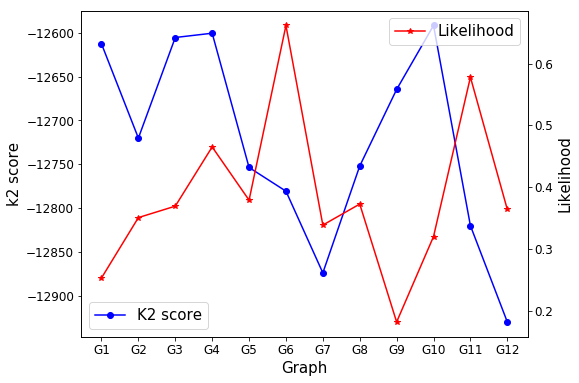

In [15]:
import matplotlib.pyplot as plt
yplot=[]
xplot=[]
yplot2=[]

for i in range(len(result)):
    yplot.append(result[i][2])
    xplot.append("G"+str(i+1))
    yplot2.append(np.prod(result[i][1]))
plt.figure(figsize=(8,6))
ax1 = plt.subplot(1,1,1)
ax1.plot(xplot,yplot,color='b',marker='o',label="K2 score")
ax1.set_xlabel("Graph", fontsize=15)
ax1.set_ylabel("k2 score", fontsize=15)
ax1.tick_params(labelsize=12)
ax1.legend(fontsize=15)
ax2 = ax1.twinx()
ax2.plot(xplot,yplot2,color='r',marker='*',label="Likelihood")
ax2.set_ylabel("Likelihood", fontsize=15)
ax2.tick_params(labelsize=12)
ax2.legend(fontsize=15)
plt.show()


### The most and least probable combination of variables 

In [16]:
# choose the 10th graph as best model
print("The most probable varaibles: ",getBestfeature(Px,graphs[9],cpd_label,cpd_value,"max"))
print("The least probable varaibles: ",getBestfeature(Px,graphs[9],cpd_label,cpd_value,"min"))

The most probable varaibles:  (0.018702748124235728, array([0, 0, 1, 0, 0, 3]))
The least probable varaibles:  (8.963204763986013e-07, array([1, 1, 2, 0, 1, 0]))


# Task 3

In [17]:
index=9 # select the index of best model in result list
best_model_bay=result[index][0] # best bayesian model
best_model_markov=best_model_bay.to_markov_model() # best Markov model
var_value={'x1':4,'x2':5,'x3':3,'x4':4,'x5':4,'x6':5} # value for all variables

In [18]:
# Evaluate Markov model, computing time may be different for each run
start_time=time.time()
for i in range(10):
    inference_markov=VariableElimination(best_model_markov)
    q_markov=inferencecal(['x1','x2','x3','x4','x5'],'x6',inference_markov,var_value)
print("---Markov network: %s seconds ---" % (time.time() - start_time))


/Users/huo/.pyvenv/pgmpy/lib/python3.6/site-packages/pgmpy-0.1.7-py3.6.egg/pgmpy/factors/discrete/DiscreteFactor.py:586: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]
/Users/huo/.pyvenv/pgmpy/lib/python3.6/site-packages/pgmpy-0.1.7-py3.6.egg/pgmpy/factors/discrete/DiscreteFactor.py:598: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi1.values = phi1.values[slice_]


---Markov network: 1.0632848739624023 seconds ---


In [19]:
# Evaluate Bayesian model, computing time may be different for each run
start_time=time.time()
for i in range(10):
    inference_bay=VariableElimination(best_model_bay)
    q_bay=inferencecal(['x1','x2','x3','x4','x5'],'x6',inference_bay,var_value)
print("---Bayesian network: %s seconds ---" % (time.time() - start_time))

---Bayesian network: 1.0269381999969482 seconds ---


In [20]:
# The inference difference
print("The sum of squared difference between Bayesian and Markov model",ssd(q_markov,q_bay,['x1','x2','x3','x4','x5']))


The sum of squared difference between Bayesian and Markov model 4.81482486096809e-35


# Task 4
- Use pgmpy build-in structural learning to find best topology of Bayesian network
- Based on the "best" toplogy construct several networks and evaluate their likelihood

In [21]:
df=pd.read_csv("AND-Features.csv") # Dataframe of AND features
df=df.drop(columns=["Unnamed: 0","img_id"])


In [22]:
def getTruefreq(df):
    freqlist=[]
    for index in df.columns:
        data=np.array(df[index])
        values=np.unique(data)
        onefreq=[]
        for val in values:
            freq=np.where(data==val)[0].shape[0]
            onefreq.append(freq)
            
        freqlist.append(onefreq)
    return freqlist
def getLikelihood_log(freq_truth,marg_fit):#calculate ratio between sampled likelihood and true likelihood
    freq_array=np.array(freq_truth)
    marg_array=np.array(marg_fit)
    num=marg_array.shape[0]
    out=np.zeros((num,))
    for i in range(num):
        if len(marg_array[i])==0: # treat the missing variable's likelihood as zero
            out[i]=0
            continue
        product=1
        sums=0
        prob=marg_array[i] # calculate marginal
        freq=freq_array[i] # ground truth frequency
        n=np.sum(freq)
        
        for j in range(len(prob)):
#             print(n,j)
            factor=comb(n,freq[j])
#             product=product*factor*(prob[j]**freq[j])
            sums=sums+np.log(factor)+freq[j]*np.log(prob[j])
            n=n-freq[j]
#         out[i]=product
            out[i]=sums
    return out

### Search for best model

In [23]:
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, BicScore,BdeuScore
est = HillClimbSearch(df, scoring_method=K2Score(df)) # using K2 score search
best_model_K2 = est.estimate()
est = HillClimbSearch(df, scoring_method=BicScore(df))# using Bic score search
best_model_Bic=est.estimate()
est = HillClimbSearch(df, scoring_method=BdeuScore(df))# using Bdeu score search
best_model_Bdeu=est.estimate()

print("K2 score of three models: ",K2Score(df).score(best_model_K2),K2Score(df).score(best_model_Bic),K2Score(df).score(best_model_Bdeu))
print("Bic score of three models: ",BicScore(df).score(best_model_K2),BicScore(df).score(best_model_Bic),BicScore(df).score(best_model_Bdeu))
print("Bdeu score of three models: ",BdeuScore(df).score(best_model_K2),BdeuScore(df).score(best_model_Bic),BdeuScore(df).score(best_model_Bdeu))


K2 score of three models:  -9462.704892371388 -9482.609140296396 -9475.69673132839
Bic score of three models:  -9592.191583228434 -9530.944116866705 -9552.837194293083
Bdeu score of three models:  -9477.81619275221 -9472.662816252163 -9464.872419813964


In [24]:
# Print the edges of best esitmated model using K2 score
best_model_K2.edges()

OutEdgeView([('f3', 'f4'), ('f3', 'f9'), ('f3', 'f8'), ('f5', 'f9'), ('f5', 'f3'), ('f9', 'f8'), ('f9', 'f7'), ('f9', 'f1'), ('f9', 'f6'), ('f9', 'f2'), ('f9', 'f4')])

### Synthesize model

In [25]:
graph_AND=[[('f1','f2'),('f2','f3'),('f3','f4'),('f4','f5'),('f5','f6'),('f6','f7'),('f7','f8'),('f8','f9')],
           [('f1','f2'),('f2','f3'),('f2','f4'),('f4','f5'),('f4','f6'),('f6','f7'),('f7','f8'),('f8','f9')],
           [('f4','f3'),('f3','f9'),('f9','f6'),('f6','f7'),('f7','f5'),('f5','f1'),('f1','f2'),('f2','f8')],
           [('f9','f8'),('f8','f7'),('f7','f6'),('f6','f5'),('f5','f4'),('f4','f3'),('f3','f2'),('f2','f1')],
           [('f1','f2'),('f1','f3'),('f2','f4'),('f2','f5'),('f3','f6'),('f3','f7'),('f4','f8'),('f4','f9')],
           ]

def synthesizemodel(graph_AND):
    score=[]
    model=[]
    for graph in graph_AND:# add edges in graph
        model_AND_1=BayesianModel(graph)
        K2=K2Score(df).score(model_AND_1)
        score.append(K2)
        model.append(model_AND_1)
    # build a model with all independent variables
    edge=[]
    node=['f1','f2','f3','f4','f5','f6','f7','f8','f9']
    model_AND_1=BayesianModel(edge)
    model_AND_1.add_nodes_from(node)
    K2=K2Score(df).score(model_AND_1)
    score.append(K2)
    model.append(model_AND_1)
    return score,model
synmodel_AND=synthesizemodel(graph_AND)
print("K2 score of synthesized models",synmodel_AND[0])
    

K2 score of synthesized models [-9686.408332971836, -9812.991321901833, -9758.18135402707, -9681.7477463154, -9884.639630515157, -9815.419375135185]


### Calculate log-likelihood

In [26]:
from pgmpy.estimators import BayesianEstimator,MaximumLikelihoodEstimator
var_list=['f1','f2','f3','f4','f5','f6','f7','f8','f9'] # all variables
freq_truth_AND=getTruefreq(df)

lh_list=[] # list to record log-likelihood for all models
for item in synmodel_AND[1]: # loop all synthesized models
    model=item
    
#     estimator = BayesianEstimator(model, df)
#     cpd_est=estimator.get_parameters(prior_type='BDeu', equivalent_sample_size=5)
    estimator = MaximumLikelihoodEstimator(model, df)# estimate CPDs
    cpd_est=estimator.get_parameters()
    model.add_cpds(*cpd_est)
    infer_AND=VariableElimination(model)
    marginal_dict=infer_AND.query(var_list)
    marginal_matrix=[]
    
    for var in var_list:
        arr=marginal_dict[var].values.tolist()
        marginal_matrix.append(arr)
    print(marginal_matrix) # print the marginal probabilities
    lh_list.append(getLikelihood_log(freq_truth_AND,marginal_matrix))

[[0.12670565302144307, 0.3021442495126714, 0.3460038986354775, 0.225146198830408], [0.17738791423001943, 0.5165692007797271, 0.13060428849902564, 0.011695906432748543, 0.1637426900584793], [0.12865497076023452, 0.835282651072124, 0.036062378167641476], [0.34600389863547737, 0.21345029239766106, 0.10526315789473689, 0.30799220272904493, 0.027290448343079917], [0.17836257309941517, 0.03703703703703703, 0.7719298245614036, 0.01267056530214425], [0.014619883040935672, 0.20175438596491227, 0.6023391812865496, 0.18128654970760236], [0.46686159844054587, 0.3430799220272905, 0.08576998050682262, 0.10428849902534114], [0.1705653021442495, 0.23294346978557506, 0.2553606237816764, 0.20662768031189085, 0.13450292397660818], [0.22124756335282644, 0.7787524366471736]]
[[0.12670565302144302, 0.30214424951267055, 0.3460038986354769, 0.22514619883040948], [0.17738791423001957, 0.5165692007797269, 0.13060428849902542, 0.011695906432748539, 0.16374269005847952], [0.12865497076023452, 0.8352826510721245, 

In [190]:
print("Log likelihood for all synthesized models: \n",lh_list)

Log likelihood for all synthesized models: 
 [array([-10.25084932, -12.20943433,  -5.99764396, -12.72922177,
        -8.34247691,  -9.14306511,  -9.88490807, -13.45781827,
        -3.50677268]), array([-10.25084932, -12.20943433,  -5.99764396, -12.72922177,
        -8.34247691,  -9.14306511,  -9.88490807, -13.45781827,
        -3.50677268]), array([-10.25084932, -12.20943433,  -5.99764396, -12.72922177,
        -8.34247691,  -9.14306511,  -9.88490807, -13.45781827,
        -3.50677268]), array([-10.25084932, -12.20943433,  -5.99764396, -12.72922177,
        -8.34247691,  -9.14306511,  -9.88490807, -13.45781827,
        -3.50677268]), array([-10.25084932, -12.20943433,  -5.99764396, -12.72922177,
        -8.34247691,  -9.14306511,  -9.88490807, -13.45781827,
        -3.50677268]), array([-10.25084932, -12.20943433,  -5.99764396, -12.72922177,
        -8.34247691,  -9.14306511,  -9.88490807, -13.45781827,
        -3.50677268])]


In [208]:
# Get log likelihood for the best model with highest k2 score
model=best_model_K2
    
estimator = MaximumLikelihoodEstimator(model, df)
cpd_est=estimator.get_parameters()
model.add_cpds(*cpd_est)
infer_AND=VariableElimination(model)
marginal_dict=infer_AND.query(var_list)
marginal_matrix=[]

for var in var_list:
    arr=marginal_dict[var].values.tolist()
    marginal_matrix.append(arr)
best=getLikelihood_log(freq_truth_AND,marginal_matrix)
